In [1]:
from NotebookLib import *
import GateSimulation
GateSimulation  = reload(GateSimulation)
sim = GateSimulation.Simulation('O-x-O')

Initializing system O-x-O ...
Constructing states and excitations ...
Constructing ground and first-excited statespace ...
Constructing gs_hamiltonian ...
Constructing e1_hamiltonian ...
Constructing interactions V_plus and V_minus ...
Constructing NJ_hamiltonian ...
Inverting NJ_hamiltonian ...


Error in atexit._run_exitfuncs:
Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/IPython/core/history.py", line 576, in end_session
    self.db.execute("""UPDATE sessions SET end=?, num_cmds=? WHERE
sqlite3.OperationalError: disk I/O error


Constructing eff_hamiltonian and effective lindblad operators ...

System  O-x-O  initialized in 29.6 seconds.

Preparing Superoperator sub-class
Preparing Analytical sub-class

Done!


# Obtain grid(s) of performance

In [37]:
# Global Parameters 
kSweep = [0.98]   #[0.995]
CSweep = [10]#[10,15]#,20,25]     #[20,25,30]
SplitSweep = [10]#[3,5,10]  #[3,5,10]

# Dimensions of first grid for optimization  --- Give odd numbers
DeNum = 11
DENum = 11
tgNum = 11
rotNum = 3  

# Limits of the grid
## DE will be multiplied by  np.sqrt(C_val)/gamma_val
DE_min = 0.05 
DE_max = 2
tg_min = 0.9
tg_max = 1.1
rot_min = 0.95
rot_max = 1.05

## Using analytical

In [38]:
gamma_val = sim.parameters['gamma']

SplitSweep = [spl*gamma_val for spl in SplitSweep] # for gamma_val = 1 it is not necessary

AllParams = [(a,b,c) for a in kSweep for b in CSweep for c in SplitSweep] # Create a 3-d grid for hardware parameters

TotalParamElems = NumElemsInList(AllParams)
CurrentNumberOfSimulations = 1
for (k, C_val , max_split) in AllParams:
    print(f'Simulating {CurrentNumberOfSimulations} out of {TotalParamElems}')
    CurrentNumberOfSimulations +=1
    
    c_val = k/ (4-4*k)
    # Optimization Parameters  --- Give odd numbers
    # De
    DeSweep = np.linspace(0,max_split , num = DeNum)
    # DE
    DESweep = np.linspace(DE_min , DE_max , num = DENum) * np.sqrt(C_val)/gamma_val
    # GateTime
    tgSweep = np.linspace(tg_min,tg_max , num = tgNum)
    # Rotations
    rotSweep = np.linspace(rot_min,rot_max , num = rotNum)


    ParamsSweep = [DeSweep ,DESweep,tgSweep,rotSweep ]
    ResultsShape = tuple([np.shape(param)[0] for param in ParamsSweep])

    Psucc = np.zeros(ResultsShape)
    Fidelity =  np.zeros(ResultsShape)
    GateTime =  np.zeros(ResultsShape)
    Concurrence =  np.zeros(ResultsShape)
    Rotations =  np.zeros(ResultsShape,dtype=tuple)
    sim.Analytical.obtain_gate_performance_hardware(C_val,c_val,max_split)


    def simulation_process(De_val,DE_val,tg_ratio,rot_ratio ):
        
        ii = np.where( DeSweep == De_val)[0][0]
        jj = np.where( DESweep == DE_val)[0][0]
        kk = np.where( tgSweep == tg_ratio)[0][0]
        ll = np.where( rotSweep == rot_ratio)[0][0]
        
        index = (ii , jj , kk, ll )


        subs_dictionary = {sg.var('De') : De_val , sg.var('DE') : De_val 
                        , sg.var('tgr'): tg_ratio, sg.var('rot_r'):rot_ratio}
        
        HL_dict = sim.Analytical.HL_dict_hw.copy()
        for key in HL_dict:
            if type(HL_dict[key]) is type(sg.var('x')): HL_dict[key] = HL_dict[key].subs(subs_dictionary)
        HL_dict = { **HL_dict ,**subs_dictionary }
        gate_time = sg.real( sim.Analytical.gate_time_symbolic.subs( HL_dict ))
        HL_dict[sg.var('tgs')] =  gate_time
        subs_dictionary[sg.var('tgs')] =  gate_time
        p_success = sg.real(sim.Analytical.p_success_symbolic.subs(HL_dict))
        try:    
            subs_dictionary[sg.var('pss')]   = p_success
            HL_dict[sg.var('pss')]   = p_success
            #fidelity = sg.real(sim.Analytical.fidelity_symbolic.subs( HL_dict))
            fid_3_ghz = sg.real(sim.Analytical.fidelity_ghz3_symbolic.subs( HL_dict))
            fidelity = fid_3_ghz
            #ket_vector = sim.Analytical.PureEvolutionVectorSg.column().subs(De=De_val,DE=DE_val,pss=p_success,tgs = gate_time )
            #concurrence = GateSimulation.concurrence_from_ket( ket_vector )
        except ValueError:
            fidelity = 0

        
        return gate_time , p_success , fidelity , index

    
    all_sweeps = product(DeSweep,DESweep,tgSweep,rotSweep)
    len_all_sweeps = DeNum*DENum*tgNum*rotNum
    with mp.Pool() as pool:
        for (tg, ps,fid, index) in  tqdm.tqdm(pool.istarmap(simulation_process, all_sweeps),total=len_all_sweeps):
            GateTime[index] = tg
            Psucc[index] = ps
            Fidelity[index] = fid
            #Concurrence[index] = con
            #Rotations[index] = rot
   
 
    Directory = f'OptimizationResults/Analytical/ResC{C_val}_k{k}_Spl{max_split}_e{DeNum}_E{DENum}_t{tgNum}_r{rotNum}'
    if not os.path.exists(Directory):
        os.makedirs(Directory)
    np.save(Directory+f'/Fidelity',Fidelity)
    np.save(Directory+f'/GateTime',GateTime)
    np.save(Directory+f'/Psucc',Psucc)
    #np.save(Directory+f'/Concurrence',Concurrence)
    clear_output(wait=True)
    

Simulating 1 out of 1


100%|██████████| 3993/3993 [00:08<00:00, 466.54it/s]


## Using superoperator simulations

In [ ]:
realistic_simulation = False

gamma_val = sim.parameters['gamma']

SplitSweep = [spl*gamma_val for spl in SplitSweep] # for gamma_val = 1 it is not necessary

AllParams = [(a,b,c) for a in kSweep for b in CSweep for c in SplitSweep] # Create a 3-d grid for hardware parameters

TotalParamElems = NumElemsInList(AllParams)
CurrentNumberOfSimulations = 0
for (k, C_val , max_split) in AllParams:
    #progressBar(CurrentNumberOfSimulations, TotalParamElems, barLength = 60)
    CurrentNumberOfSimulations +=1
    
    c_val = k/ (4-4*k)
    # Optimization Parameters  --- Give odd numbers
    # De
    DeSweep = np.linspace(0,max_split , num = DeNum)
    # DE
    
    DESweep = np.linspace(0.1 , 2 , num = DENum) * np.sqrt(C_val)/gamma_val
    # GateTime
    
    tgSweep = np.linspace(0.90,1.10 , num = tgNum)

    ParamsSweep = [DeSweep ,DESweep,tgSweep ]
    ResultsShape = tuple([np.shape(param)[0] for param in ParamsSweep])

    Psucc = np.zeros(ResultsShape)
    Fidelity =  np.zeros(ResultsShape)
    GateTime =  np.zeros(ResultsShape)
    Concurrence = np.zeros(ResultsShape)


    def simulation_process(De_val,DE_val,tg_ratio ):
        
        
        ii = np.where( DeSweep == De_val)[0][0]
        jj = np.where( DESweep == DE_val)[0][0]
        kk = np.where( tgSweep == tg_ratio)[0][0]
        index = (ii , jj , kk)

        super_dict = {'C' : C_val ,'c': c_val,\
                'De': De_val ,'De0': De_val - max_split, \
                'DE': DE_val ,'tgr': tg_ratio}
        performance = sim.Superoperator.Simulate(super_dict , realistic = realistic_simulation) 
        gate_time = performance['gate_time']
        p_success = performance['p_success']
        fidelity = performance['fidelity']
        #concurrence = performance['concurrence']

        return gate_time , p_success , fidelity , index

    pool = mp.Pool()
    all_sweeps = product(DeSweep,DESweep,tgSweep)
    count_tot = DeNum * DENum * tgNum
    count = 0 
    for (tg, ps,fid, index) in pool.starmap(simulation_process,all_sweeps):
        GateTime[index] = tg
        Psucc[index] = ps
        Fidelity[index] = fid
        #Concurrence[index] = con
        
        
   
 
    Directory = f'OptimizationResults/Superoperator/ResC{C_val}_k{k}_Spl{max_split}_e{DeNum}_E{DENum}_t{tgNum}'
    if not os.path.exists(Directory):
        os.makedirs(Directory)
    np.save(Directory+f'/Fidelity',Fidelity)
    np.save(Directory+f'/GateTime',GateTime)
    np.save(Directory+f'/Psucc',Psucc)
    #np.save(Directory+f'/Concurrence',Concurrence)

KeyboardInterrupt: 

# Plot result

<>:39: DeprecationWarning: invalid escape sequence \L
<>:39: DeprecationWarning: invalid escape sequence \L
<ipython-input-39-07d390f8a687>:39: DeprecationWarning: invalid escape sequence \L
  ax.set_title(f'Gate Performance vs Cooperativity & Detuning Split \nfor $k={kPlot} \Leftrightarrow c = {np.round(cPlot,decimals=1)}$\n'+r' $(\Delta_e,\Delta_E,t_g,rot)$')


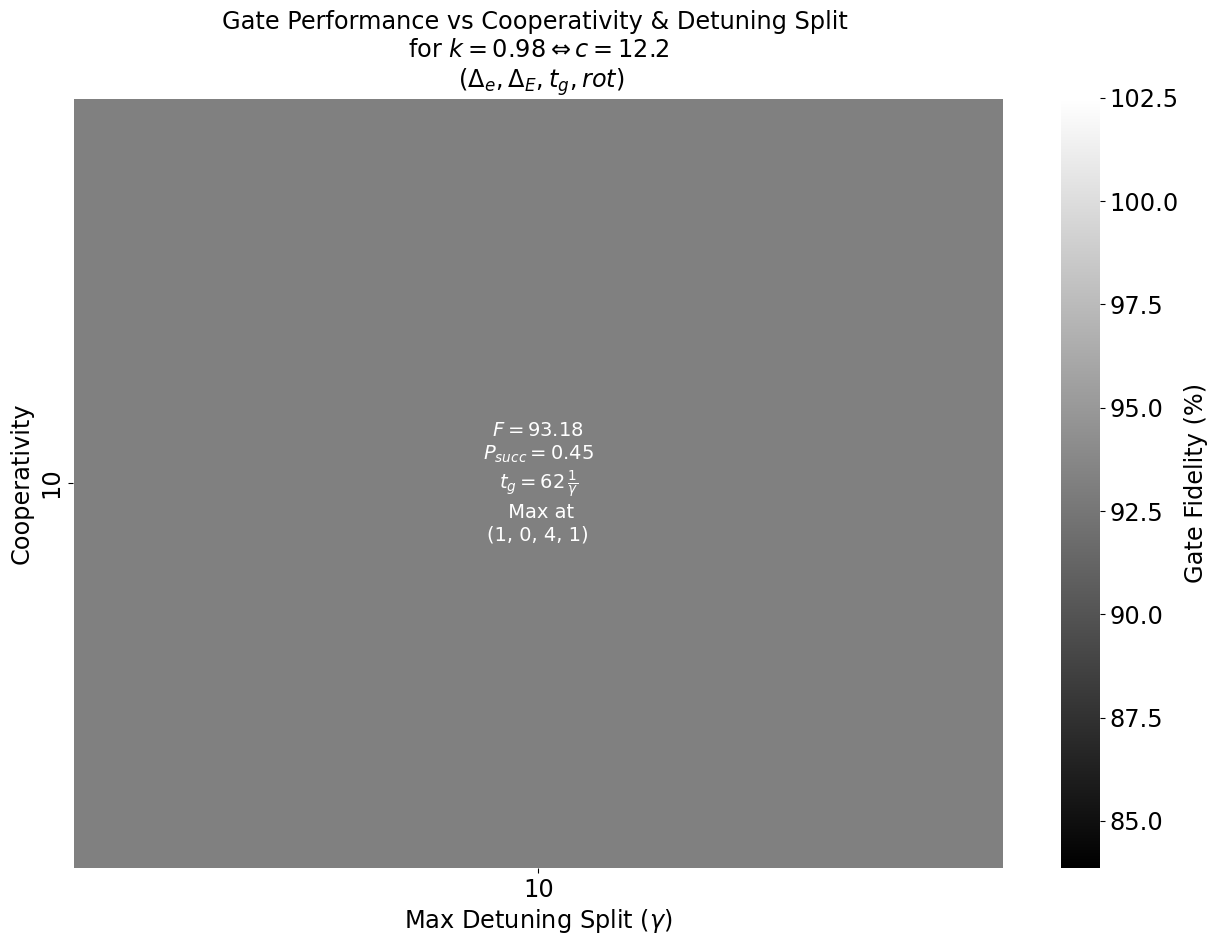

In [39]:
Analytical = True
kPlot = kSweep[0]
cPlot = kPlot / (4-4*kPlot)



if Analytical:
    subdir = 'Analytical'
else:
    subdir = 'Superoperator'
AllLabels = [["" for i in range(len(SplitSweep))]for j in range(len(CSweep))]
FidelityPlot = np.zeros(np.array(AllLabels).shape)
for (i,c) in enumerate(CSweep):
    for (j,spl) in enumerate(SplitSweep):
        DataDirectory = f'OptimizationResults/Analytical/ResC{c}_k{kPlot}_Spl{spl}_e{DeNum}_E{DENum}_t{tgNum}_r{rotNum}/'
        GateTimeData = np.load(DataDirectory+"GateTime.npy")
        FidelityData = np.load(DataDirectory+"Fidelity.npy")
        PsuccData = np.load(DataDirectory+"Psucc.npy")
        #ConcurrenceData = np.load(DataDirectory+"Concurrence.npy")

        #argm = ArgMin( GateSimulation.gate_performance_cost_function(FidelityData,PsuccData,GateTimeData) ) 
        argm = ArgMin(1-FidelityData)
        FidelityPlot[i][j] = FidelityData[argm]

        AllLabels[i][j] += '$F='+ str(np.round(FidelityData[argm]*100,decimals=2))+'%$\n'
        AllLabels[i][j] += '$P_{succ}='+ str(np.round(PsuccData[argm]*100,decimals=2))+'%$\n'
        AllLabels[i][j] += '$t_g='+ str(int(GateTimeData[argm]))+r' \,\frac{1}{\gamma}$'
        AllLabels[i][j] += f'\n Max at\n{argm}'
        


fig, ax = plt.subplots()


ax = sns.heatmap(FidelityPlot*100,yticklabels=CSweep,xticklabels=SplitSweep,cmap='gray', linewidth=0.5,annot=AllLabels, fmt = ''\
    ,cbar_kws={'label': 'Gate Fidelity (%)'}, annot_kws={"size": 14}) #Greys
ax.set_ylabel('Cooperativity')
ax.set_xlabel(r'Max Detuning Split $(\gamma)$')
ax.set_title(f'Gate Performance vs Cooperativity & Detuning Split \nfor $k={kPlot} \Leftrightarrow c = {np.round(cPlot,decimals=1)}$\n'+r' $(\Delta_e,\Delta_E,t_g,rot)$')
plt.show() 
figure = ax.get_figure()
figure.savefig(f'plots/OptimizedHeatmap.svg',transparent=False)

In [34]:
init_params = [DeSweep[argm[0]],DESweep[argm[1]],tgSweep[argm[2]],rotSweep[argm[3]]]
print(GateTimeData[argm])
print(FidelityData[argm])

57.11772857419612
0.9695177628586176


In [14]:
sim.Analytical.optimize_gate_performance_hardware(init_params)
print(sim.Analytical.optimized_dict)

{'fidelity': 0.9492869455856261, 'p_success': 0.4334525913436266, 'gate_time': 2.097598864786638, 'tgr': 0.8033230710023522, 'De': 6.355403902976283, 'DE': 3.474904428732481, 'r1r': 1.2522940386929466, 'r2r': 1.1784404635028882}


In [15]:
sim.Analytical.hardware_dict

{'C': 100, 'c': 249.74999999999977, 'max_split': 10}

In [16]:
super = sim.Superoperator

super_variables = ['C','c','De','De0','DE','tgr','r1r','r2r']

super_dict = dict()
super_dict['De0'] =   sim.Analytical.optimized_dict['De'] - sim.Analytical.hardware_dict['max_split']
for param in super_variables:
    if param in sim.Analytical.hardware_dict:
        exec(f"super_dict['{param}'] = sim.Analytical.hardware_dict['{param}'] ")
    elif param in sim.Analytical.optimized_dict:
        exec(f"super_dict['{param}'] = sim.Analytical.optimized_dict['{param}'] ")

#super.realistic_parameters['gamma_g'] = 0.01
#super.realistic_parameters['gamma_f'] = 0.99
super.Simulate(super_dict,realistic = True)

{'fidelity': 0.9471475925835855,
 'p_success': 0.4374446295000347,
 'gate_time': 2.0975988647866375,
 'concurrence': 0.812830199036987}

In [17]:
super.performance

{'fidelity': 0.9471475925835855,
 'p_success': 0.4374446295000347,
 'gate_time': 2.0975988647866375,
 'concurrence': 0.812830199036987}

In [24]:
super.optimize_gate_performance_hardware(init_params , sim.Analytical.hardware_dict , max_iter = 10)

Cost function value: 0.05058254490031233 , fidelity=0.94942 , p_success=0.48418, tg=3.88955
Cost function value: -0.07403560481375633 , fidelity=0.95345 , p_success=0.47067, tg=3.79465
Cost function value: -0.06521402707136098 , fidelity=0.95421 , p_success=0.48091, tg=4.17403
Cost function value: -0.06503662203448551 , fidelity=0.95574 , p_success=0.46981, tg=4.08403
Cost function value: -0.07448179025294993 , fidelity=0.9549 , p_success=0.48418, tg=3.88955
Cost function value: -0.07448179025294993 , fidelity=0.95235 , p_success=0.48418, tg=3.88955
Cost function value: -0.06672473856334978 , fidelity=0.95977 , p_success=0.47181, tg=4.04206
step = 1, (De,DE,tgr,r1,r2) = [5.     4.8    0.9    0.9975 1.    ] 
Cost function value: -0.07767895231690661 , fidelity=0.95257 , p_success=0.48807, tg=3.82264
Cost function value: 0.05359897811942149 , fidelity=0.9464 , p_success=0.49824, tg=3.68049
step = 2, (De,DE,tgr,r1,r2) = [5.14   4.9344 0.8622 0.9766 1.028 ] 
Cost function value: -0.0821244

In [19]:
super.optimized_dict 

{'fidelity': 0.9508513233731039,
 'p_success': 0.48851048125750124,
 'gate_time': 3.0355387915923635,
 'tgr': 0.8606162303999991,
 'De': 5.319092480000004,
 'DE': 4.213482700799999,
 'r1r': 1.0671715712000014,
 'r2r': 1.0705384960000006}

In [23]:
maximum_cost = 1
def performance_makes_sense(fidelity,p_success,gate_time):
    '''
    Checks if performance parameters make sense.
    '''
    performance_array = np.array([fidelity,p_success,gate_time])
    if np.any(np.zeros(3) >= performance_array):
        return False
    if np.any(np.full_like(performance_array,np.inf) == performance_array):
        return False
    if fidelity > 1.001 or p_success > 1.001:
        return False
    return True

def gate_performance_cost_function(fidelity,p_success,gate_time):
    '''
    Cost function to be minimized in order to achieve maximum performance.
    Designed to handle arrays as well.
    The function should be smaller than 1.
    '''

    def performance_function(fidelity,p_success,gate_time):
        '''
        Here the actual cost function is defined.
        '''
        if performance_makes_sense(fidelity, p_success, gate_time):
            fidelity_cap = 0.946
            avg_time_to_success = max(gate_time/p_success , 1e-10)
            if fidelity >= fidelity_cap:
                cost = maximum_cost - fidelity_cap - 1/avg_time_to_success
            else:
                cost = maximum_cost - fidelity
        else:
            # if the performance parameters dont make sense, give the maximum cost 
            cost = maximum_cost
        return cost
    
    # handling of arrays
    if type(fidelity) != np.ndarray:
        return performance_function(fidelity,p_success,gate_time)
    else:
        cost_array = np.zeros_like(fidelity)
        for idx, _ in np.ndenumerate(fidelity):
            cost_array[idx] = performance_function(fidelity[idx] ,p_success[idx] ,gate_time[idx] )
        return cost_array
GateSimulation  = reload(GateSimulation)

In [2]:
from GateSimulationFunctions import *
def obtain_gate_performance_hardware(self, C_val , c_val, max_split):
    '''
    Obtain the gate performance given the hardware setting. Detunings are still allowed to vary.
    '''
    
    De0_val =  sg.var('De') - max_split
    
    GSRange = range(self.setup.gs_dim)

    CcDe0_dict = {sg.var('C'): C_val , sg.var('c'): c_val ,sg.var('De0'): De0_val}

    H = [self.basic_substitution(self.setup.eff_hamiltonian_gs[diag,diag]).subs(CcDe0_dict) for diag in GSRange]

    H_symbolic = [ sg.var(f'H_{diag}') for diag in GSRange] 

    H_dict = {sg.var(f'H_{diag}'): H[diag] for diag in GSRange}
    
    self.gate_time_symbolic =  sg.abs_symbolic( np.pi  /(H_symbolic[3]+H_symbolic[0]-H_symbolic[1]-H_symbolic[2]) ) * sg.var('tgr') #tgr : gate time ratio
    
    gate_time_symbolic = sg.var('tgs')


    eff_eff_hamiltonian_symbolic = [-1j*H_symbolic[i] for i in GSRange ]


    loss_factors_symbolic = [0 for i in GSRange]
    
    L_symbolic =[]
    L_dict = {}
    for lind_op in range(self.lind_op_number):
        for which in GSRange:   
            l_symbolic =  sg.var(sg.var(f'L_{lind_op}_{which}' , domain='complex'))
            
            L_num = self.EffLindbladElements[lind_op][which]
            if type(L_num) is type(sg.var('x')): L_num = L_num.subs(C=C_val, c=c_val, De0 = De0_val)
            
            L_symbolic.append( l_symbolic)
            L_dict[l_symbolic] = L_num
            
            loss_symbolic = l_symbolic* sg.conjugate(l_symbolic)

            eff_eff_hamiltonian_symbolic[which]  -= loss_symbolic / 2
            loss_factors_symbolic[which] += loss_symbolic * gate_time_symbolic

    

    init_state = np.array([1,1,1,1])/2

    p_success_symbolic = 0
    for i in GSRange:
        p_success_symbolic += init_state[i]**2 * np.exp( - loss_factors_symbolic[i])
    self.p_success_symbolic = p_success_symbolic
    
    PSuccess_symbolic = sg.var('pss')


    pure_evolution_unitary_symbolic = []  
    for i in GSRange:
        evolution_symbolic = sg.exp(eff_eff_hamiltonian_symbolic[i]*gate_time_symbolic)  
        pure_evolution_unitary_symbolic.append( evolution_symbolic )

    evolution_unitary_symbolic = sg.Matrix(sg.SR,np.diag(pure_evolution_unitary_symbolic))/ sg.sqrt(PSuccess_symbolic)
    

    # Post process rotations
    rot_r = sg.var('rot_r')
    r1 = - gate_time_symbolic * (H_symbolic[0] - H_symbolic[2]) * rot_r  
    dim = self.setup.gs_dim
    R1_symbolic = sg.Matrix(sg.SR,np.zeros((dim,dim)))
    R1_list = [sg.exp(sg.I*r1*i) for i in range(2) for j in range(2) ]
    for i in range(dim):
        R1_symbolic[i,i] = R1_list[i]

    r2 = -gate_time_symbolic * (H_symbolic[0] - H_symbolic[1]) * rot_r
    R2_symbolic = sg.Matrix(sg.SR,np.zeros((dim,dim)))
    R2_list = [sg.exp(sg.I*r2*j) for i in range(2) for j in range(2) ]
    for i in range(dim):    
        R2_symbolic[i,i] = R2_list[i]

    # Simulate

    FinalVector = sg.vector(np.array([1,1,1,-1])/2)


    unitary_with_rotations_symbolic = R1_symbolic*R2_symbolic*evolution_unitary_symbolic
    
    # The following expressions are not fully expressed in terms of detunings necessarily.
    self.fidelity_symbolic_hw        = sg.abs_symbolic(( unitary_with_rotations_symbolic*sg.vector(init_state) ) *FinalVector) 
    self.fidelity_ghz3_symbolic_hw   = GHZ_3_symbolic_fidelity_from_evolution(unitary_with_rotations_symbolic) 


    self.substitution_dict = {**H_dict , **L_dict}


    # A dictionary of the hardware setting
    self.hardware_dict = {'C' : C_val , 'c' : c_val , 'max_split' : max_split}

In [3]:
C_val = c_val = max_split = 100
obtain_gate_performance_hardware(sim.Analytical, C_val , c_val, max_split)

In [4]:
import cProfile


In [5]:
%load_ext line_profiler
%lprun -f obtain_gate_performance_hardware obtain_gate_performance_hardware(sim.Analytical, C_val , c_val, max_split)

Timer unit: 1e-06 s

Total time: 10.5547 s
File: <ipython-input-2-2268a05db9b5>
Function: obtain_gate_performance_hardware at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           def obtain_gate_performance_hardware(self, C_val , c_val, max_split):
     3                                               '''
     4                                               Obtain the gate performance given the hardware setting. Detunings are still allowed to vary.
     5                                               '''
     6                                               
     7         1         80.0     80.0      0.0      De0_val =  sg.var('De') - max_split
     8                                               
     9         1          5.0      5.0      0.0      GSRange = range(self.setup.gs_dim)
    10                                           
    11         1         29.0     29.0      0.0      CcDe0_dict = {sg.var('C'): C_val , s